In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,GlobalAveragePooling2D,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.applications.densenet import DenseNet201,preprocess_input

In [2]:
# set random seed

# Set a seed value
seed_value= 1680

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value) # for later versions
# tf.random.set_seed(seed_value) # for old versions:

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
# model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
from keras import backend as K
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
# for old versions:
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [3]:
# Get path to all TRAIN & TEST files
#print("glob walk file")
train_paths = glob.glob('../input/automated-optical-inspection/train_images/*/*')
test_paths = glob.glob('../input/automated-optical-inspection/test_images/*/*')

print("No. Files in Train: {:,} pictures".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,} pictures".format(len(test_paths)), "\n")

No. Files in Train: 5,056 pictures 
No. Files in Test: 19,278 pictures 



In [4]:
# label data
traindf = pd.read_csv('../input/automated-optical-inspection/train.csv',dtype=str)
testdf = pd.read_csv('../input/automated-optical-inspection/test.csv',dtype=str)
print("train.csv:\n",traindf.head())
print("\n\ntest.csv:\n",testdf.head())

train.csv:
                 ID Label
0  train_00000.jpg     0
1  train_00001.jpg     1
2  train_00002.jpg     1
3  train_00003.jpg     5
4  train_00004.jpg     5


test.csv:
                ID
0  test_00001.jpg
1  test_00002.jpg
2  test_00003.jpg
3  test_00004.jpg
4  test_00005.jpg


In [5]:
img_ex = cv2.imread('../input/automated-optical-inspection/train_images/train_images/train_00000.jpg')
print(img_ex.shape) #dim
#cv2.imshow('test', img_ex)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

(256, 256, 3)


In [6]:
# Hyperparamters 超參數則是則是由人為給定，例如神經網路的層數、損失函數、卷積核的大小、學習率等等
resize = 128
batchsize = 32

# Data
train_gen = ImageDataGenerator(  #deal with picture(data argmentation)
    rescale=1./255.,
    #zca_whitening=True, # zca白化的作用是針對圖片進行PCA降維操作，減少圖片的冗餘信息，保留最重要的特徵
    #rotation_range=40,# Degree range for random rotations # 指定旋轉角度範圍,在 [0, 指定角度] 範圍內進行隨機角度旋轉
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2, # 線性變換推移 #讓所有點的x坐標(或者y坐標)保持不變，而對應的y坐標(或者x坐標)則按比例發生平移，且平移的大小和該點到x軸(或y軸)的垂直距離成正比
    #zoom_range=0.2, # 可以讓圖片在長或寬的方向進行放大
    horizontal_flip=True, # 水平翻轉
    vertical_flip=True, # 上下翻轉
    fill_mode='nearest', # 填充模式，當對圖片進行平移、放縮、錯切等操作時，圖片中會出現一些缺失的地方，設定這些缺失的地方該用什麼方式補全
    validation_split=0.2,  # set validation split
)
# training data
#train_data = train_gen.flow_from_directory(
train_data = train_gen.flow_from_dataframe(
    dataframe = traindf,
    directory = "../input/automated-optical-inspection/train_images/train_images",# 目標目錄
    x_col="ID",
    y_col="Label",
    target_size=(resize, resize), # picture change to resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode="categorical",
    #class_mode="binary",
    batch_size = batchsize,
    shuffle=True, # 是否隨機播放數據
    #seed=seed_value,
    #save_format="png",
    follow_links=False,
    subset="training", # set as training data
    interpolation="nearest",
)
# validation data
#valid_data = train_gen.flow_from_directory(
valid_data = train_gen.flow_from_dataframe(
    dataframe = traindf,
    directory = "../input/automated-optical-inspection/train_images/train_images",# 目標目錄 # same directory as training data
    x_col="ID",
    y_col="Label",
    target_size=(resize, resize), # 所有影像調整為 resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode="categorical",
    batch_size = batchsize,
    shuffle=True, # 是否隨機播放數據
    #seed=seed_value,
    #save_format="png",
    follow_links=False,
    subset="validation", # set as validation data
    interpolation="nearest",
)
# test data
test_gen = ImageDataGenerator(rescale=1./255.)
#test_data = test_gen.flow_from_directory(
test_data = test_gen.flow_from_dataframe(
    dataframe = testdf,
    directory = "../input/automated-optical-inspection/test_images/test_images",# 目標目錄
    x_col="ID",
    target_size=(resize, resize), # 所有影像調整為 resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode=None, # important!!!
    #class_mode="categorical",
    #class_mode="binary",
    batch_size = batchsize,
    shuffle=False, # 是否隨機播放數據
    #seed=seed_value,
    #save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 4045 validated image filenames belonging to 6 classes.
Found 1011 validated image filenames belonging to 6 classes.
Found 19278 validated image filenames.


In [ ]:
# for i in range(len(train_data)):
#     batch = train_data[i]

#     print('images in batch:', len(x))

#     for image in x:
#         plot
#x = train_data.next()
#print(train_data[0])
# for i in range(0,4):
#      image = x[i]
#      plt.imshow(image)
#      plt.show()

In [7]:
# Reweight data

from collections import Counter
counter = Counter(train_data.classes)
print(counter)
max_val = float(max(counter.values())) 
class_weights_dic = {class_id : max_val/num_images for class_id, num_images in counter.items()} 
print(class_weights_dic)

sorted_items = sorted(class_weights_dic.items()) # Get key-value pairs and Sort dictionary by key
class_weights_dict = {class_id : weight for class_id, weight in sorted_items}
print(class_weights_dict)

# from collections import OrderedDict
# class_weights_dict = OrderedDict(sorted(class_weights_dic.items()))
# print(class_weights_dict)
        
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
#weight_for_0 = (1 / neg)*(total)/2.0 
#weight_for_1 = (1 / pos)*(total)/2.0
#class_weight_dic = {0: weight_for_0, 1: weight_for_1}
#print('Weight for class 0: {:.2f}'.format(weight_for_0))
#print('Weight for class 1: {:.2f}'.format(weight_for_1))

Counter({0: 1073, 5: 1028, 1: 795, 3: 610, 4: 377, 2: 162})
{4: 2.8461538461538463, 5: 1.043774319066148, 2: 6.6234567901234565, 3: 1.759016393442623, 1: 1.349685534591195, 0: 1.0}
{0: 1.0, 1: 1.349685534591195, 2: 6.6234567901234565, 3: 1.759016393442623, 4: 2.8461538461538463, 5: 1.043774319066148}


In [8]:
base_model = DenseNet201(include_top=False,input_shape=(resize, resize, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(6, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=x)

model.summary()
print('the number of layers in this model:'+str(len(model.layers)))

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['accuracy'])

74842112/74836368 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

In [ ]:
# # Build model

# model = Sequential()

# # ## Block0----------------------------------------------
# # # convolutional layer
# # model.add(Conv2D(filters=32,
# #                  kernel_size=(3,3),
# #                  strides=(1,1),
# #                  input_shape=(resize, resize, 3),
# #                  padding='same',
# #                  activation=None,
# #                  ))
# # model.add(BatchNormalization())
# # model.add(Activation('relu'))
# # # convolutional layer
# # model.add(Conv2D(filters=32,
# #                  kernel_size=(3,3),
# #                  strides=(1,1),
# #                  padding='same',
# #                  activation=None,
# #                  ))
# # model.add(BatchNormalization())
# # model.add(Activation('relu'))
# # # pooling layer
# # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Block1----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=64,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  input_shape=(resize, resize, 3),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=64,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Block2----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=128,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=128,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Block3----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=256,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=256,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=256,
#                 kernel_size=(3,3),
#                 strides=(1,1),
#                 padding='same',
#                 activation=None,
#                 ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Block4----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=512,
#                 kernel_size=(3,3),
#                 strides=(1,1),
#                 padding='same',
#                 activation=None,
#                 ))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.1))
# #model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Fully connected layer----------------------------------------------
# # flatten layer (2D -> 1D)
# # model.add(Flatten())
# # # dropout layer
# # model.add(Dropout(0.2))

# # # dense layer
# # model.add(Dense(512,activation='relu'))
# # # dropout layer
# # model.add(Dropout(0.2))

# # # dense layer
# # model.add(Dense(128,activation='relu'))
# # # dropout layer
# # model.add(Dropout(0.2))

# ## Global Average Pooling 2D layer----------------------------------------------
# model.add(GlobalAveragePooling2D())

# # output layer
# model.add(Dense(6,activation='softmax'))
# model.summary()

# model.compile(optimizer=optimizers.Adam(learning_rate=0.00002),
#               loss='categorical_crossentropy',
#               #loss='binary_crossentropy',
#               metrics=['accuracy'])

In [9]:
# training

# callback setting
checkpoint = ModelCheckpoint(f'CNNv5_weights_seed{seed_value}.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True,
                             save_weights_only=True, mode='max')
# earlystop = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=20, verbose=1, mode='max', baseline=None,
#                           restore_best_weights=False)
# reduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, cooldown=2,
#                              min_lr=1e-10, mode='max')
earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='min', baseline=None,
                          restore_best_weights=False)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, cooldown=2,
                             min_lr=1e-10, mode='min')

callbacks_list = [checkpoint, earlystop, reduceLR]

# train
train_history = model.fit_generator(
    train_data,
    epochs = 100,
    #steps_per_epoch = 80,
    validation_data = valid_data,
    callbacks = callbacks_list,
    # The class weights go here
    class_weight = class_weights_dict,
    
#validation_dat nerator(dataFrameTest,expectedFrameTest,batch_size*2),
#validation_steps = dataFrame.shape[0]/batch_size*2
)
print("*+"*60)
print('Finish\n')

model.save_weights(f'CNNv5_weights_seed{seed_value}_finished.hdf5')
model.save(f'CNNv5_model_seed{seed_value}.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
127/127 [==============================] - 73s 368ms/step - loss: 2.4168 - accuracy: 0.3815 - val_loss: 1.3841 - val_accuracy: 0.3956
Epoch 2/100
127/127 [==============================] - 22s 170ms/step - loss: 0.5892 - accuracy: 0.8950 - val_loss: 1.0710 - val_accuracy: 0.5786
Epoch 3/100
127/127 [==============================] - 22s 172ms/step - loss: 0.3246 - accuracy: 0.9436 - val_loss: 0.6832 - val_accuracy: 0.7310
Epoch 4/100
127/127 [==============================] - 21s 167ms/step - loss: 0.2127 - accuracy: 0.9641 - val_loss: 0.4889 - val_accuracy: 0.7962
Epoch 5/100
127/127 [==============================] - 22s 170ms/step - loss: 0.1616 - accuracy: 0.9774 - val_loss: 0.2117 - val_accuracy: 0.9367
Epoch 6/100
127/127 [==============================] - 22s 170ms/step - loss: 0.1137 - accuracy: 0.9814 - val_loss: 0.0945 - val_accuracy: 0.9733
Epoch 7/100
127/127 [==============================] - 21s 167ms/step - loss: 0.0884 - accuracy: 0.9866 - val_loss: 0.0780 -

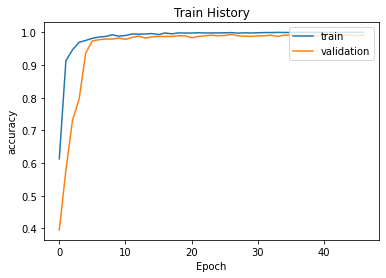

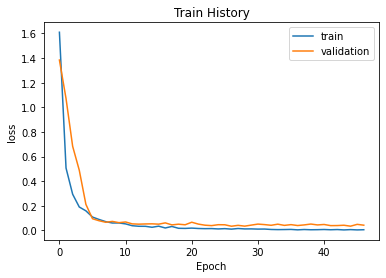

In [10]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper right')
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [24]:
scores = model.evaluate(valid_data)
print('accuracy=',scores[1])

scores = model.evaluate(train_data)
print('accuracy=',scores[1])

32/32 [==============================] - 3s 78ms/step - loss: 0.0452 - accuracy: 0.9911
accuracy= 0.9910979270935059
127/127 [==============================] - 11s 86ms/step - loss: 4.1676e-04 - accuracy: 1.0000
accuracy= 1.0


In [21]:
model.load_weights(f'CNNv5_weights_seed{seed_value}_finished.hdf5')

In [12]:
# predict

# if you forget to reset the test_generator you will get outputs in a weird order
test_data.reset() # need to reset the test_generator before whenever you call the predict_generator

pred = model.predict_generator(test_data,
    verbose=1
)
#pred = model.predict_classes(test_data)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


603/603 [==============================] - 176s 286ms/step


In [13]:
# write predict result to file

#predictions=[]
predicted_class_indices = np.argmax(pred,axis=1) # 沿著行(axis=0)或列(axis=1)查詢最大值的索引號
labels = train_data.class_indices
labels = dict((v,k) for k,v in labels.items())
# 建立代碼標籤與真實標籤(種類名稱)的關係
predictions = [labels[i] for i in predicted_class_indices]

filenames = test_data.filenames
results=pd.DataFrame({"ID":filenames,
                      "Label":predictions})
results.to_csv(f'CNNv5_s{seed_value}.csv',index=False)
print(labels)
print(len(predictions))

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
19278


In [15]:
# 計算「混淆矩陣」(Confusion Matrix)，顯示訓練集(train set)分類的正確及錯認總和數

scores = model.evaluate(train_data)
print('accuracy=',scores[1])

# Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix


train_data.shuffle = False # 取消 shuffle 以對應正確的 label 和 predict class
# train_data.index_array = None
train_data.reset()

CM_train_Y_pred = model.predict_generator(train_data, verbose=1)
CM_train_y_pred = np.argmax(CM_train_Y_pred, axis=1)

print('\nConfusion Matrix (sklearn version)')
print(confusion_matrix(train_data.classes, CM_train_y_pred)) # labels = [0, 1, 2, 3, 4, 5]

print('\nConfusion Matrix (pandas version)')
data_train_y_label = np.array(train_data.classes)
print( pd.crosstab(data_train_y_label, CM_train_y_pred, rownames=['Label'], colnames=['Predict']) )

print('\nClassification Report')
target_names = ['0 normal', '1 void', '2 horizontal defect', '3 vertical defect', '4 edge defect', '5 particle']
print(classification_report(train_data.classes, CM_train_y_pred, target_names=target_names))

127/127 [==============================] - 11s 84ms/step - loss: 3.7165e-04 - accuracy: 1.0000
accuracy= 1.0


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


127/127 [==============================] - 11s 85ms/step

Confusion Matrix (sklearn version)
[[1073    0    0    0    0    0]
 [   0  795    0    0    0    0]
 [   0    0  162    0    0    0]
 [   0    0    0  610    0    0]
 [   0    0    0    0  377    0]
 [   0    0    0    0    0 1028]]

Confusion Matrix (pandas version)
Predict     0    1    2    3    4     5
Label                                  
0        1073    0    0    0    0     0
1           0  795    0    0    0     0
2           0    0  162    0    0     0
3           0    0    0  610    0     0
4           0    0    0    0  377     0
5           0    0    0    0    0  1028

Classification Report
                     precision    recall  f1-score   support

           0 normal       1.00      1.00      1.00      1073
             1 void       1.00      1.00      1.00       795
2 horizontal defect       1.00      1.00      1.00       162
  3 vertical defect       1.00      1.00      1.00       610
      4 edge defect     

In [17]:
# 計算「混淆矩陣」(Confusion Matrix)，顯示驗證集(validation set)分類的正確及錯認總和數

scores = model.evaluate(valid_data)
print('accuracy=',scores[1])

# Confution Matrix and Classification Report

valid_data.reset()
valid_data.shuffle = False # 取消 shuffle 以對應正確的 label 和 predict class
# valid_data.index_array = None

CM_valid_Y_pred = model.predict_generator(valid_data, verbose=1)
CM_valid_y_pred = np.argmax(CM_valid_Y_pred, axis=1)

print('\nConfusion Matrix (sklearn version)')
print(confusion_matrix(valid_data.classes, CM_valid_y_pred)) # labels = [0, 1, 2, 3, 4, 5]

print('\nConfusion Matrix (pandas version)')
data_valid_y_label = np.array(valid_data.classes)
print( pd.crosstab(data_valid_y_label, CM_valid_y_pred, rownames=['Label'], colnames=['Predict']) )

print('\nClassification Report')
target_names = ['0 normal', '1 void', '2 horizontal defect', '3 vertical defect', '4 edge defect', '5 particle']
print(classification_report(valid_data.classes, CM_valid_y_pred, target_names=target_names))

32/32 [==============================] - 3s 93ms/step - loss: 0.0417 - accuracy: 0.9881
accuracy= 0.9881305694580078


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


32/32 [==============================] - 3s 80ms/step

Confusion Matrix (sklearn version)
[[272   0   3   0   0   0]
 [  1 187   0   0   0   1]
 [  0   0  38   0   0   0]
 [  0   0   0 146   0   0]
 [  0   0   0   2 101   0]
 [  0   1   0   0   0 259]]

Confusion Matrix (pandas version)
Predict    0    1   2    3    4    5
Label                               
0        272    0   3    0    0    0
1          1  187   0    0    0    1
2          0    0  38    0    0    0
3          0    0   0  146    0    0
4          0    0   0    2  101    0
5          0    1   0    0    0  259

Classification Report
                     precision    recall  f1-score   support

           0 normal       1.00      0.99      0.99       275
             1 void       0.99      0.99      0.99       189
2 horizontal defect       0.93      1.00      0.96        38
  3 vertical defect       0.99      1.00      0.99       146
      4 edge defect       1.00      0.98      0.99       103
         5 particle       